<h2><center> The Effects of Spatial Agglomeration on Relative Net Profitability: a prospective look at Seoul’s retail market sector using machine learning </center></h2>

# Introduction

 Stakeholders looking to open new businesses will often dispute which part of a city they should open in. The rise of specialized localities in Seoul has made this decision process harder since entrepreneurs now have to decide whether to open business in a fiercely competitive neighborhood or risk defaulting in a less famous location. Thus, this research will use Seoul’s food markets to assess whether clustering markets holds an inherent economic and social advantage over individual markets.
 
 In particular, this research will mainly focus on restaurants, cafe's, and late-night food stores (such as chicken or pizza).

## Definitions

- **Retail Type**: is defined by a certain types of retail stores that share characteristics with other stores. This will be found using the unsupervised K-means algorithm. The focus of this research will be mainly on food and drinks.

- **Cluster**: Using DBSCAN clustering algorithms, this research will find the locations in which stores of the same *retail type* are clustered together while others of the same *retail type* are considered *outliers* based on the algorithm.


## Data

Based on the definition of our problem, some factors that will influence our discussion are:
- locations of popular districts in the city of Seoul
- types of retail stores, may it be cafe's, restauraunts, bakeries, etc.
- number of blog posts per store to determine the popularity index of the store


# Research

Before we begin, let's import all the necessary libraries for this project:

In [1]:
# Exporatory Data Analysis
import pandas as pd
import numpy as np

# Url requests & parse
import urllib.request, requests
from bs4 import BeautifulSoup

# Data Visualization
import matplotlib.pyplot as plt
import folium

# File Management
import re, os, sys
import json
from pandas.io.json import json_normalize
import pickle

In [2]:
# Helper function to retrieve large data files
def retrieve_dataframe(files) -> bool:
    # Returns True if pickled data returns. False if not pickled
    try:
        for i in range(len(files)):
            string = 'Data/'+files[i]
            temp = pd.read_pickle(string)
        print('Dataframes loaded from memory')
        return True
    except:
        print('Dataframes not in memory')
        return False

## Data Retrieval & Cleaning

### Retrieve Locations of Interest

Here, I will create a function that will utilize Kakao's map API to return *latitude* and *longitude* coordinates based on the centroids of our candidate neighborhoods. The function calls a REST API that communicates with Kakao map's servers and returns a json file containing information about the query. Here, since I am only interested in the specific location, I will return only the coordinates.

Eventually, these coordinates will give us an area where we will run K-means clustering algorithms to find the *types* of stores using their most defining characteristics.

In [3]:
Kakao_appkey = 'KakaoAK 1dd987b2b0f2925d8b7ea121281310c8'

# Returns the latitude and longitude portions of the GET request
def getLatLng(addr):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query='+addr
    headers = {"Authorization": Kakao_appkey}
    result = json.loads(str(requests.get(url,headers=headers).text))
    try:
        match_first = result['documents'][0]['address']
        return float(match_first['y']),float(match_first['x'])
    except IndexError:
        print("Not documented in API")
        
    return None

def queryAddress(query, lat='37.5665', lng='126.9780', radius='20000'):
    # This function will return the locations with query within a radius of this.radius meters (default 20km)
    # Default coordinates centered in Seoul
    url = 'https://dapi.kakao.com/v2/local/search/keyword.json?y={}&x={}&radius={}&query={}'.format(lat, lng, radius, query)
    headers = {"Authorization": Kakao_appkey}
    result = json.loads(str(requests.get(url,headers=headers).text))
    try:
        return float(result['documents'][0]['y']), float(result['documents'][0]['x'])
    except IndexError:
        return None

Seoul_lat, Seoul_lng = getLatLng("서울")

Now that we have a function for returning the coordinates of a specific address, let's use an excel file containing all the subway stations and create a DataFrame.

**Note**: *We are doing this assuming that the area surrounding the subway stations are usually neighborhoods of high interest*

In [4]:
df = pd.read_excel("Data/subwayStationNames.xlsx")
df = df.drop(['연번', '한자', '중국어', '일본어'], axis=1)
df.head(3)

호선   역명             영문
0  1호선  서울역  Seoul Station
1  1호선   시청      City Hall
2  1호선   종각        Jonggak

Next, we find the locations for each of the stations and use the above functions to find the coordinates and append to the DataFrame. At the same time, we drop any row in our DataFrame that contains locations that are not within a 20km radius based on the center of Seoul.

In [5]:
# First store the station names in query format in an array
stations = []

for idx in df.index:
    name = (''.join(df['역명'][idx].split(' '))).split('(', 1)[0]
    if name[-1] != '역':
        name = name + '역'
    stations.append(name)

# Then we iterate over the array and find the coordinates for each element

station_lat = []
station_lng = []

for idx in range(len(stations)):
    try:
        lat, lng = queryAddress(stations[idx])
        station_lat.append(lat)
        station_lng.append(lng)
    except TypeError:
        print("{} not found within map radius".format(stations[idx]))
        df.drop([idx], axis=0, inplace=True) # drop the row containing unneeded locations
    

df['Latitude'] = station_lat
df['Longitude'] = station_lng
df = df.reset_index()

삼산체육관역 not found within map radius
굴포천역 not found within map radius
부평구청역 not found within map radius
남한산성입구역 not found within map radius
단대오거리역 not found within map radius
신흥역 not found within map radius


Finally let's clean up our DataFrame so that it is ready to be used for our analysis

In [6]:
df = df.drop(['index'], axis=1)
df = df.rename(columns={'호선': 'LineNumber', '역명' : 'StationKor', '영문' : 'StationEng'})
df.head()

LineNumber StationKor       StationEng   Latitude   Longitude
0        1호선        서울역    Seoul Station  37.554679  126.970607
1        1호선         시청        City Hall  37.565344  126.977199
2        1호선         종각          Jonggak  37.570229  126.983152
3        1호선       종로3가  Jongno 3(sam)ga  37.570421  126.992153
4        1호선       종로5가    Jongno 5(o)ga  37.570976  127.001539

Now that we have all the locational data for our neighborhoods, let's visualize the data:

- Seoul center location
- Candidate neighborhoods based upon proximity to stations

In [7]:
map_Seoul = folium.Map(location=[Seoul_lat, Seoul_lng], zoom_start=12)
for index, row in df.iterrows():
    label = '{}, {}'.format(row[1], row[0])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row[3], row[4]],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#333333',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_Seoul)

map_Seoul

### Data Exploration

Now that we have our neighborhoods, we can use either Kakao's inherent search API to find the nearest retail stores of interest, or we can also use FourSquare's API to accomplish the same task. In my research, I will use FoureSquare's venue API to look specifically for restauraunts, cafe's and late-night food stores.

### Nearby retail stores using FourSquare API

Foursquare credentials are in the cell below

In [8]:
CLIENT_ID = 'RHLWHDGP2UUV5VAZOUNVEZOC3G5WQ00DPXYVYQIZIQ1BUY1G' # your Foursquare ID
CLIENT_SECRET = 'DAMEJ4SSMIYJ2UXOBS1I33K1DR0VG42RGQHTLBKKZSKPLRZZ' # your Foursquare Secret
VERSION = '20200228' # Foursquare API version

Create a "filter" of sorts that will find which type of restaurant a certain venue is.

In [9]:
food_category = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues

korean_restaurant_categories = [
    '4bf58dd8d48988d113941735','56aa371be4b08b9a8d5734e4','56aa371be4b08b9a8d5734f0',
    '56aa371be4b08b9a8d5734e7','56aa371be4b08b9a8d5734ed','56aa371be4b08b9a8d5734ea',
    '52af0bd33cf9994f4e043bdd','4bf58dd8d48988d145941735','4bf58dd8d48988d111941735',
    '55a59bace4b013909087cb24','55a59bace4b013909087cb15','55a59bace4b013909087cb27',
    '4bf58dd8d48988d1d2941735','55a59bace4b013909087cb2a','4bf58dd8d48988d1d1941735',
    '4bf58dd8d48988d149941735','4bf58dd8d48988d14a941735','4bf58dd8d48988d1df931735',
    '52e81612bcbc57f1066b79f4','4bf58dd8d48988d16c941735','4bf58dd8d48988d108941735',
    '4bf58dd8d48988d109941735','52e81612bcbc57f1066b7a05','4bf58dd8d48988d10c941735',
    '52e81612bcbc57f1066b79ff','4bf58dd8d48988d10f941735','4bf58dd8d48988d110941735',
    '4bf58dd8d48988d1c1941735','4bf58dd8d48988d153941735','4bf58dd8d48988d151941735',
    '4bf58dd8d48988d1c4941735','4bf58dd8d48988d1ce941735','4bf58dd8d48988d1cc941735',
    '56aa371be4b08b9a8d573538','4bf58dd8d48988d1d3941735'
]
# Further research can also yield the best places to open a bar

cafe_categories = [
    '4bf58dd8d48988d1dc931735','4bf58dd8d48988d1c5941735','4bf58dd8d48988d1bd941735','4bf58dd8d48988d112941735',
    '4bf58dd8d48988d148941735','52e81612bcbc57f1066b7a0a','5744ccdfe4b0c0459246b4e2','4bf58dd8d48988d1c9941735',
    '512e7cae91d4cbb4e5efe0af','4bf58dd8d48988d1bc941735','4bf58dd8d48988d1d0941735','4bf58dd8d48988d146941735',
    '4bf58dd8d48988d1e0931735','4bf58dd8d48988d16d941735','52e81612bcbc57f1066b7a0c','4bf58dd8d48988d16a941735',
    '4bf58dd8d48988d179941735', '4bf58dd8d48988d143941735','4bf58dd8d48988d14f941735'
]

late_night_categories = [
    '52e81612bcbc57f1066b7a06','4bf58dd8d48988d1ca941735','4bf58dd8d48988d14c941735','4d4ae6fc7a7b7dea34424761'
]

Now, implement functions required to filter the data and GET the venues using the API.

In [10]:
# Use the filters I defined above to categorize the venue into either a restauraunt, cafe, or late night joint
def is_venue(categories, specific_filter=None):
    specific = False
    for c in categories:
        category_id = c[1]
        if not(specific_filter is None) and (category_id in specific_filter):
            specific = True
    return specific

# Parses through JSON file to get the categories of venues
def get_categories(categories):
    return [(a['name'], a['id']) for a in categories]

# GET request to Foursquare API returns venues with key categories
def getNearbyVenues(lat, lon, category, radius, limit=100):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, category, radius, limit)
    #url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    #CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, radius, limit)
    results = requests.get(url).json()['response']['groups'][0]['items']
    venues = [(item['venue']['id'],
                item['venue']['name'],
                get_categories(item['venue']['categories']),
                (item['venue']['location']['lat'], item['venue']['location']['lng']),
                item['venue']['location']['formattedAddress'][0]) for item in results]        
    return venues

# Returns a dictionary containing all the venues using a GET request from a query of (names, lats, lngs) with a radius of 500 meters
def createTable(names, lats, lngs, radius=500):
    restaurants = {}
    korean_restaurants = {}
    cafes = {}
    night_snacks = {}
    all_venues = []
    print("loading data", end=' ')
    for name, lat, lon in zip(names, lats, lngs):
        venues = getNearbyVenues(lat, lon, food_category, radius)
        area = []
        for venue in venues:
            # Split the venue into key categories
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_coord = venue[3]
            venue_address = venue[4]
            restaurant = (name, venue_categories[0][0], venue_name, venue_coord[0], venue_coord[1], venue_address)
            area.append(restaurant)
            restaurants[venue_id] = restaurant
            
            # append the venue to a particular dataframe based upon our filter from above.
            if is_venue(venue_categories, specific_filter=korean_restaurant_categories):
                korean_restaurants[venue_id] = restaurant
            elif is_venue(venue_categories, specific_filter=cafe_categories):
                cafes[venue_id] = restaurant
            elif is_venue(venue_categories, specific_filter=late_night_categories):
                night_snacks[venue_id] = restaurant
        if len(area) == 0:
            area.append((name, 'none', 'none', 'none', 'none', 'none'))
        all_venues.append(area)
        print('.', end='')
    print('\nFinished loading data.')
    return restaurants, korean_restaurants, cafes, night_snacks, all_venues

Now we just need to load all of our data into the main memory. Then, once we have our data, we can create new DataFrames using the dictionaries created.

In [11]:
# If loaded, use downloaded data. If not loaded, use API to create new DataFrames
loaded = retrieve_dataframe(['df_all.pkl', 'df_korean.pkl', 'df_cafes.pkl', 'df_night.pkl'])
if not loaded:
    restaurants, korean_restaurants, cafes, night_snacks, all_venues = createTable(df['StationKor'], df['Latitude'], df['Longitude'])
    df_all = pd.DataFrame.from_dict(restaurants).transpose().reset_index().drop(['index'], axis=1)
    df_all.to_pickle('Data/df_all.pkl')
    
    df_korean = pd.DataFrame.from_dict(korean_restaurants).transpose().reset_index().drop(['index'], axis=1)
    df_korean.to_pickle('Data/df_korean.pkl')
    
    df_cafes = pd.DataFrame.from_dict(cafes).transpose().reset_index().drop(['index'], axis=1)
    df_cafes.to_pickle('Data/df_cafes.pkl')
    
    df_night = pd.DataFrame.from_dict(night_snacks).transpose().reset_index().drop(['index'], axis=1)
    df_night.to_pickle('Data/df_night.pkl')
elif loaded:
    df_all = pd.read_pickle('Data/df_all.pkl')
    df_korean = pd.read_pickle('Data/df_korean.pkl')
    df_cafes = pd.read_pickle('Data/df_cafes.pkl')
    df_night = pd.read_pickle('Data/df_night.pkl')

df_all.head()

Dataframes loaded from memory


0                  1                           2        3  \
0         서울역               Café  THE HOUSE 1932 (더하우스 1932)  37.5555   
1         서울역  Korean Restaurant                      금자네생등심  37.5574   
2         서울역             Bakery      Paris Baguette (파리바게뜨)   37.555   
3         서울역  French Restaurant               Seasons (시즌즈)  37.5552   
4  충정로(경기대입구)   Ramen Restaurant                        유즈라멘  37.5569   

         4                   5  
0  126.967           만리재로35길 5  
1  126.972         중구 통일로 22-4  
2  126.972  중구 통일로 1 (PB서울역사점)  
3  126.975           중구 소월로 50  
4  126.968         중구 만리재로 217

## Implement Machine Learning

### K-Means Clustering the Data

Now that we have our data and retail stores in Seoul, we can quickly run a K-Means algorithm to cluster our data. The following code will train our data with various *k* values in order to find the optimal *k*.

Since the purpose of this research is to see how clustering affects a store's ability to earn money, we start clustering the stores based on their retail type relative to the nearby station in which they are located.

### One-Hot Encoding the DataFrames

In order to implement a K-Means algorithm on the DataFrames, we need to first apply one-hot encoding on the DataFrames. The following function will take in a DataFrame as input and output a DataFrame that is one-hot encoded.

In [12]:
def one_hot_encode(dataframe):
    # one hot encoding
    onehot = pd.get_dummies(dataframe[[1]], prefix="", prefix_sep="")
    
    # add defining features back to the one hot dataframe
    onehot[['Neighborhood', 'Latitude', 'Longitude']] = dataframe[[0,3,4]]
    
    # move the defining columns back to the first three columns of the dataframe
    fixed_columns = [onehot.columns[-3],onehot.columns[-2],onehot.columns[-1]] + list(onehot.columns[:-3])
    onehot = onehot[fixed_columns]
    
    # return the one hot encoded DataFrame
    return onehot

all_grouped = one_hot_encode(df_all).groupby('Neighborhood').mean().reset_index()
korean_grouped = one_hot_encode(df_korean).groupby('Neighborhood').mean().reset_index()
cafes_grouped = one_hot_encode(df_cafes).groupby('Neighborhood').mean().reset_index()
night_grouped = one_hot_encode(df_night).groupby('Neighborhood').mean().reset_index()

In [13]:
one_hot_encode(df_all).sample(5)

Neighborhood Latitude Longitude  African Restaurant  American Restaurant  \
71      회현(남대문시장)  37.5622   126.976                   0                    0   
3436         김포공항  37.5587   126.804                   0                    0   
2955     수유(강북구청)  37.6368   127.025                   0                    0   
3735           마포  37.5409   126.946                   0                    0   
2072           홍제    37.59   126.943                   0                    0   

      Asian Restaurant  BBQ Joint  Bagel Shop  Bakery  Bistro  ...  \
71                   0          1           0       0       0  ...   
3436                 0          0           0       0       0  ...   
2955                 0          0           0       0       0  ...   
3735                 0          0           0       0       0  ...   
2072                 0          0           0       0       0  ...   

      Taco Place  Tapas Restaurant  Thai Restaurant  Theme Restaurant  \
71             0                 0                0                 0   
3436           0                 0                0                 0   
2955           0                 0                0                 0   
3735           0                 0                0                 0   
2072           0                 0                0                 0   

      Tibetan Restaurant  Turkish Restaurant  Udon Restaurant  \
71                     0                   0                0   
3436                   0                   0                0   
2955                   0                   0                0   
3735                   0                   0                0   
2072                   0                   0                0   

      Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wings Joint  
71                                0                      0            0  
3436                              0                      0            0  
2955                              0                      0            0  
3735                              0                      0            0  
2072                              0                      0            0  

[5 rows x 94 columns]

### K-Means Clustering

In order to cluster our data, we first need to find the optimal *k* for the number of clusters we should create. This is done by utilizing the **elbow test** where we plot the sum of squared distances from individual points to its respective cluster centroids. The implementation is shown below.

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Normalizes the data
def transform_data(data):
    mms = MinMaxScaler()
    mms.fit(data)
    return mms.transform(data)

# Returns the data required to plot graph
def plot_optimal_elbow(data):
    """
    Note: make sure that the data parameter contains *normalized* data
    """
    # Fit to model and append to array
    Sum_of_squared_distances = []
    K = range(1,31)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(data)
        Sum_of_squared_distances.append(km.inertia_)
    
    return K, Sum_of_squared_distances
    
# Helper function -> returns a dataframe that is readable to humans
def helper_fix_dataframe(dataframe, labels, from_dataframe):
    df = dataframe
    df.insert(0, 'Cluster', labels)
    df.insert(0, 'Name', from_dataframe[2])
    df.insert(0, 'Type', from_dataframe[1])
    df.insert(0, 'Station', from_dataframe[0])
    
    df = df[['Station', 'Type', 'Name', 'Cluster', 'Latitude', 'Longitude']]
    return df

**Find the optimal *k* for all the DataFrames**:

Using the Elbow Method, we can find the optimal number of *k* for each of our dataframes. We will find the *k*s using the below graphs.

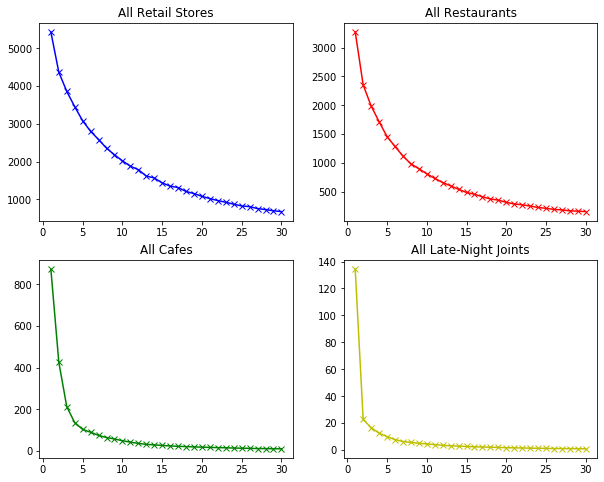

In [15]:
figure, axes = plt.subplots(nrows=2, ncols=2)

all_ungrouped = one_hot_encode(df_all).drop('Neighborhood', 1)
K0, SSD0 = plot_optimal_elbow(transform_data(all_ungrouped))
axes[0, 0].plot(K0, SSD0, 'bx-')
axes[0, 0].title.set_text("All Retail Stores")
# all
# We can see in the below graph that the optimal k is around 15

korean_ungrouped = one_hot_encode(df_korean).drop('Neighborhood', 1)
K1, SSD1 = plot_optimal_elbow(transform_data(korean_ungrouped))
axes[0, 1].plot(K1, SSD1, 'rx-')
axes[0, 1].title.set_text("All Restaurants")

# korean restaurants
# We can see in the below graph that the optimal k is around 15

cafe_ungrouped = one_hot_encode(df_cafes).drop('Neighborhood', 1)
K2, SSD2 = plot_optimal_elbow(transform_data(cafe_ungrouped))
axes[1, 0].plot(K2, SSD2, 'gx-')
axes[1, 0].title.set_text("All Cafes")

# cafes
# We can see in the below graph that the optimal k is close to 5

night_ungrouped = one_hot_encode(df_night).drop('Neighborhood', 1)
K3, SSD3 = plot_optimal_elbow(transform_data(night_ungrouped))
axes[1, 1].plot(K3, SSD3, 'yx-')
axes[1, 1].title.set_text("All Late-Night Joints")

# night restaurants
# We can see in the below graph that the optimal k is around 2


figure.set_figheight(8)
figure.set_figwidth(10)

Now that we have our *k* values for each of our DataFrames, we can train our data sets using these values.
Then, we use a helper function to clean the resulting data.

In [16]:
# Train the datasets

kmeans_all = KMeans(n_clusters=15, random_state=0).fit(transform_data(all_ungrouped))
kmeans_korean = KMeans(n_clusters=15, random_state=0).fit(transform_data(korean_ungrouped))
kmeans_cafes = KMeans(n_clusters=5, random_state=0).fit(transform_data(cafe_ungrouped))
kmeans_night = KMeans(n_clusters=2, random_state=0).fit(transform_data(night_ungrouped))

all_ungrouped = helper_fix_dataframe(all_ungrouped, kmeans_all.labels_, df_all)
korean_ungrouped = helper_fix_dataframe(korean_ungrouped, kmeans_korean.labels_, df_korean)
cafe_ungrouped = helper_fix_dataframe(cafe_ungrouped, kmeans_cafes.labels_, df_cafes)
night_ungrouped = helper_fix_dataframe(night_ungrouped, kmeans_night.labels_, df_night)

In [17]:
# Read the data we have so far

all_ungrouped.sample(10)

Station                Type                   Name  Cluster Latitude  \
116      시 청  Italian Restaurant              LaGrillia        7  37.5691   
5428      장지          Food Court             가든파이브 푸드코트        6  37.4776   
1869  신촌(지하)              Bakery    PARIS BAGUETTE Café        1   37.557   
607      성 수   Korean Restaurant                 밀본 칼국수        0  37.5465   
4825     사가정              Bakery         TOUS les JOURS        1  37.5803   
4782      하계        Noodle House                  제일제면소       10  37.6394   
2365      옥수              Bakery  Katter Allmant (카터알망)        1  37.5444   
318      동묘앞   Korean Restaurant                    진고개        0   37.572   
1925      이대   Korean Restaurant                내가 찜한 닭        0  37.5588   
680     건대입구  Seafood Restaurant                   연어상회       12  37.5421   

     Longitude  
116    126.979  
5428   127.125  
1869   126.937  
607    127.051  
4825   127.089  
4782   127.069  
2365   127.016  
318    127.011  
1925   126.945  
680    127.071

In [18]:
all_ungrouped['Cluster'].value_counts()

0     1314
6     1195
2      554
1      436
5      408
9      297
8      290
7      185
10     182
13     169
12     149
11     137
3      137
4       96
14      93
Name: Cluster, dtype: int64

### Find Outliers Using DBSCAN Clustering

Now that we clustered our data, we are going to implement DBSCAN clustering on *each of the clusters* based on euclidean distance using coordinates. This will deterimine where the clusters are most dense, and which of the data are considered outliers.

<br>

__Epsilon__: we will now determine what the best epsilon is using DMDBSCAN algorithm

__minimumSamples__: we will determine min samples using the k value from the k-means algorithm


In [19]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

def DMDBSCAN(data):
    # Transform the data
    dataset = data[['Latitude', 'Longitude']]
    dataset = np.nan_to_num(dataset)
    dataset = StandardScaler().fit_transform(dataset)
    
    # Nearest Neighbors to find distances
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(dataset)
    distances, indices = nbrs.kneighbors(dataset)
    
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    
    return distances

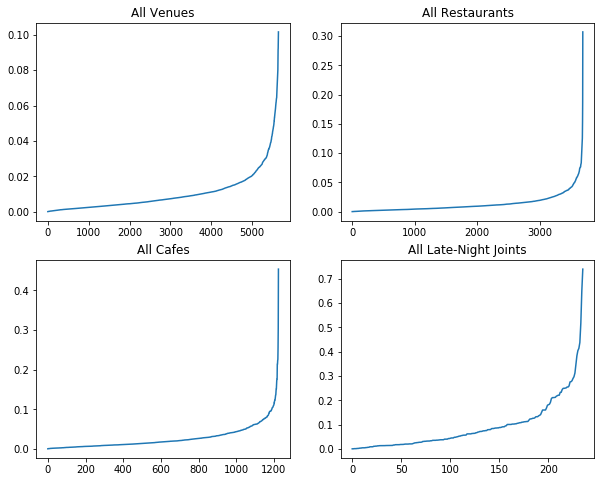

In [20]:
# Plot to see the optimal epsilon values for each data frame

figure, axes = plt.subplots(nrows=2, ncols=2)

distances1 = DMDBSCAN(all_ungrouped)
axes[0, 0].plot(distances1)
axes[0, 0].title.set_text("All Venues")

distances2 = DMDBSCAN(korean_ungrouped)
axes[0, 1].plot(distances2)
axes[0, 1].title.set_text("All Restaurants")

distances3 = DMDBSCAN(cafe_ungrouped)
axes[1, 0].plot(distances3)
axes[1, 0].title.set_text("All Cafes")

distances4 = DMDBSCAN(night_ungrouped)
axes[1, 1].plot(distances4)
axes[1, 1].title.set_text("All Late-Night Joints")

figure.set_figheight(8)
figure.set_figwidth(10)

Using the above graph as empirical evidence, we know that:

**Epsilon**: the optimal epsilon is as follows: 0.04, 0.05, 0.1, 0.2

**Min Samples**: the optimal min samples from the *k*-means clustering are 10, 10, 3, 2

In [21]:
# Implements DBSCAN Algorithm on data with epsiolon=eps, and minimum samples required as min_samples
def DBSCAN_Cluster(data, eps, min_samples):
    sklearn.utils.check_random_state(1000)
    dataset = data[['Latitude', 'Longitude']]
    dataset = np.nan_to_num(dataset)
    dataset = StandardScaler().fit_transform(dataset)
    
    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(dataset)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    df = data
    df['DB Cluster'] = labels
    realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
    clusterNum = len(set(labels)) 
    
    return df

db_all = DBSCAN_Cluster(all_ungrouped, 0.04, 10)
db_korean = DBSCAN_Cluster(korean_ungrouped, 0.05, 10)
db_cafe = DBSCAN_Cluster(cafe_ungrouped, 0.1, 3)
db_night = DBSCAN_Cluster(night_ungrouped, 0.2, 2)

In [22]:
db_all.sample(10)

Station                 Type                   Name  Cluster  \
3873  광화문(세종문화회관)           Donut Shop                Dunkin'        3   
3137           명동  Fried Chicken Joint                   치르치르       11   
371           신설동            BBQ Joint                    한우방        5   
4929           청담                 Café          G 카페 (G Cafe)        2   
5514          봉은사    Korean Restaurant             Soyon (소연)        0   
4445    녹사평(용산구청)                Diner    Gobble n' Go (고블앤고)        6   
1641        영등포구청           Bagel Shop                 코끼리베이글        6   
5502          봉은사               Bistro          COCOTTE (꼬꼬트)        6   
3653          여의도   Seafood Restaurant                어도 (漁島)       12   
5008           학동  Fried Chicken Joint  kkanbu chicken (깐부치킨)       11   

     Latitude Longitude  DB Cluster  
3873  37.5701   126.974           1  
3137  37.5646   126.984           1  
371   37.5764   127.023          -1  
4929  37.5237   127.055          83  
5514  37.5117   127.056          17  
4445   37.535   126.992          80  
1641  37.5296   126.894          -1  
5502  37.5113   127.056          17  
3653  37.5201   126.926          65  
5008  37.5147   127.033          84

### Visualize the Clusters

Now that we have our clusters, we can create a function that will plot the data by retail type. The points with a blue border are considered **outliers** and will become the focus of this study.

In [23]:
import matplotlib.cm as cm
import matplotlib.colors as colors

def map_cluster(data):
    # set color scheme for the clusters
    x = np.arange(len(data['Cluster'].value_counts()))
    ys = [i + x + (i*x)**2 for i in range(len(data['Cluster'].value_counts()))]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    
    map_S = folium.Map(location=[Seoul_lat, Seoul_lng], zoom_start=12)
    for index, row in data.iterrows():
        border_color = ('blue' if row[6] == -1 else ([0.4,0.4,0.4]))
        label = '{} Cluster, is outlier: {}'.format(row[3], row[6])
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [row[4], row[5]],
            radius = 2,
            popup=label,
            color=border_color,
            fill=True,
            fill_color=rainbow[row[3]],
            fill_opacity=0.5,
            parse_html=False
        ).add_to(map_S)
        
    return map_S

In [24]:
map_cluster(db_all)

### Retrieve the *Popularity* of Retails

Now that we have categorized our data into clusters, we now conduct a comparison of the *popularity* of the outlier points compared to the *popularity* of stores within clusters. In order to do this, however, we need to utilize Naver(a Korean equivalent to Google)'s search API in order to find the average number of blog posts and search trends of people to the stores within these areas.

In [25]:
seoul_data_appkey = '714e5362527374653736677767695a'
naver_CLIENT_ID = 'wV1d6h2eUKntr7qZBHCB'
naver_CLIENT_SECRET = 'HDtvNbIyQp'

In [26]:
# Helper function -> returns string inside parentheses
def format_string(string, is_station = 0):
    if is_station == 1:
        try:
            return ''.join(string.split('(')[0].split(' '))
        except:
            return string
    try:
        t = string.split('(')[1]
        return t.split(')')[0]
    except:
        return string

# Helper function -> returns a searchable query from a DataFrame row
def construct_naver_query(query_row)-> str:
    q_station = format_string(query_row['Station'], 1)
    q_name = format_string(query_row['Name'])
    return q_station + ' ' + q_name

# Search Function -> returns # of blog posts per query
def search_naver_query(query: str) -> int:
    encText = urllib.parse.quote(query)
    url = "https://openapi.naver.com/v1/search/blog?query=" + encText
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",naver_CLIENT_ID)
    request.add_header("X-Naver-Client-Secret",naver_CLIENT_SECRET)
    try:
        response = urllib.request.urlopen(request)
        rescode = response.getcode()
        if(rescode==200):
            response_body = response.read()
            results = response_body.decode('utf-8')
            data = json.loads(results)
            return data['total']
        else:
            print("Error Code:" + rescode)
            return 0
    except:
        print('HTTP Error on query: ', query)
        return 0

# Appends the number of blogposts of each query to a copy of the dataframe
def append_popularity_db(data):
    db = data
    print("Fetching data...")
    for index, row in db.iterrows():
        if index % 40 == 0:
            print('Searching for {}...'.format(construct_naver_query(row)))
        db.at[index, 'Pop Index'] = (search_naver_query(construct_naver_query(row)))
    print("\nLoaded data")
    return db

Here we either retrieve the data using online API's or loading data from pickled data files if we have done this beforehand.

Using the functions above, we retrieve the **number of blog reviews** per store based upon a Naver(Korean version of Google)query created with a combination of the store name, alongside the district in which the store is located.

After doing so, we can save the data into our dataframes.

In [28]:
# If loaded, use downloaded data. If not loaded, use API to create new DataFrames
loaded = retrieve_dataframe(['db_all_pop.pkl', 'db_korean_pop.pkl', 'db_cafe_pop.pkl', 'db_night_pop.pkl'])
if not loaded:
    db_all_pop = append_popularity_db(db_all)
    db_all_pop.to_pickle('Data/db_all_pop.pkl')
    
    db_korean_pop = append_popularity_db(db_korean)
    db_korean_pop.to_pickle('Data/db_korean_pop.pkl')
    
    db_cafe_pop = append_popularity_db(db_cafe)
    db_cafe_pop.to_pickle('Data/db_cafe_pop.pkl')
    
    db_night_pop = append_popularity_db(db_night)
    db_night_pop.to_pickle('Data/db_night_pop.pkl')
elif loaded:
    db_all_pop = pd.read_pickle('Data/db_all_pop.pkl')
    db_all_pop['DB Cluster'] = db_all['DB Cluster']
    
    db_korean_pop = pd.read_pickle('Data/db_korean_pop.pkl')
    db_korean_pop['DB Cluster'] = db_korean['DB Cluster']
    
    db_cafe_pop = pd.read_pickle('Data/db_cafe_pop.pkl')
    db_cafe_pop['DB Cluster'] = db_cafe['DB Cluster']
    
    db_night_pop = pd.read_pickle('Data/db_night_pop.pkl')
    db_night_pop['DB Cluster'] = db_night['DB Cluster']
    print("Loaded pickled data")

Dataframes loaded from memory
Loaded pickled data


Before we move on to the statistical inference of our data, it is imperative we clean our data by removing outliers in the number of blog reviews for our dataframes. We will do this by first finding the interquartile range and removing all outliers outside of our interquartile range.

In [29]:
# Finds the interquartile range of (col_name) and returns a DataFrame with values in (col_name) within the IQ range
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

db_all_pop_sorted = remove_outlier(db_all_pop, 'Pop Index')
db_korean_sorted = remove_outlier(db_korean_pop, 'Pop Index')
db_cafe_sorted = remove_outlier(db_cafe_pop, 'Pop Index')
db_night_sorted = remove_outlier(db_night_pop, 'Pop Index')

In [30]:
db_all_pop_sorted.sample(10)

Station               Type                        Name  Cluster  \
2482           신사          BBQ Joint                        연탄공장        5   
4569          한강진               Café           LOW COFFEE (로우커피)        2   
91    광화문(세종문화회관)             Bakery  NAPOLEON KIOSK (나폴레옹 키오스크)        1   
1711           상수               Café        100% ORIGINAL COFFEE        2   
5410           문정  Bunsik Restaurant                       골목떡볶이        6   
2913           상계             Bakery                        브레댄코        1   
3788           공덕  Korean Restaurant                         진대감        0   
3987     천호(풍납토성)             Bakery              PARIS BAGUETTE        1   
4969         강남구청        Snack Place                       부자떡볶이        6   
5204      가산디지털단지  Korean Restaurant                         동남집        0   

     Latitude Longitude  DB Cluster  Pop Index  
2482  37.5178   127.017          38      490.0  
4569  37.5372   127.002          80      474.0  
91     37.569   126.976           1       86.0  
1711  37.5491   126.919          28       22.0  
5410  37.4891   127.124          -1      946.0  
2913  37.6599   127.076          -1        6.0  
3788  37.5466   126.954          70      615.0  
3987  37.5367   127.123          -1        2.0  
4969  37.5177   127.038          84      232.0  
5204  37.4787   126.882          91      281.0

## Statistical Inference

### Visualize our Data

Let's also draw boxplots of the dataframes so we can visualize the difference of the average number of blog reviews between clustered retail stores and unclustered stores.

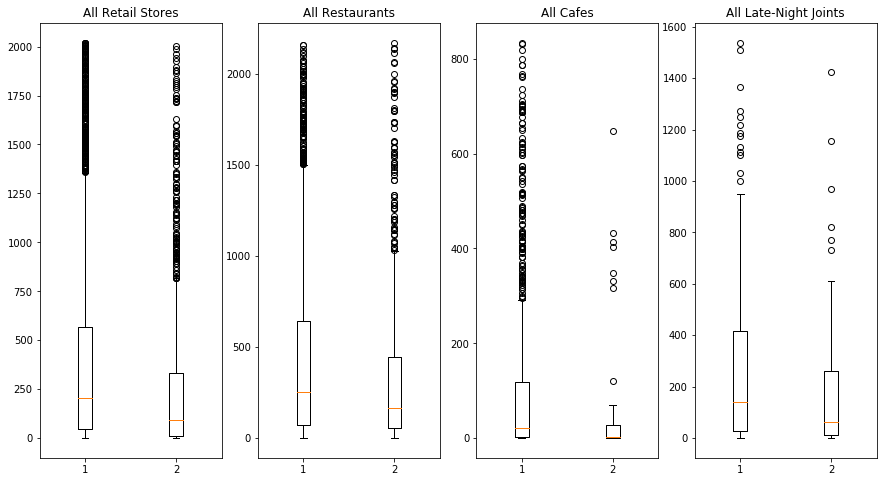

In [31]:
figure, axes = plt.subplots(nrows=1, ncols=4)

# Splits the data to create a boxplot comparing clustered and unclustered stores
def split_data(data):
    cat1 = data[data['DB Cluster'] != -1]
    cat2 = data[data['DB Cluster'] == -1]
    return cat1["Pop Index"], cat2["Pop Index"]

axes[0].boxplot(split_data(db_all_pop_sorted))
axes[0].title.set_text("All Retail Stores")
axes[1].boxplot(split_data(db_korean_sorted))
axes[1].title.set_text("All Restaurants")
axes[2].boxplot(split_data(db_cafe_sorted))
axes[2].title.set_text("All Cafes")
axes[3].boxplot(split_data(db_night_sorted))
axes[3].title.set_text("All Late-Night Joints")

figure.set_figheight(8)
figure.set_figwidth(15)

#### Explanation of Boxplots

We can see here 4 types of box plots. In order, they represent all food stores, restaurants, cafes, and late-night parlors respectively. The first box plot in each graph represents **clustered** retails, while the second box plot represents the **outlying** or unclustered retail stores.

### Two Sample One Tailed T-Test

Now that we have all the data we require, we can construct a two sample t-test to determine if there is statistical significance between average popularity of restaurants that are outliers and those that are more clustered together. This can be done because our data fits three key criteria in that they:
1. Data is normally distributed (albeit a bit right skewed)
2. The data is independent
3. The Data have similar variance


#### First construct the Null Hypothesis

Our **null** hypothesis is going to be: 

$H_{0} : \mu_{1} - \mu_{0} \leq 0$

where $\mu$ represents the average number of blog reviews a certain store received. We set the difference to less than or equal to zero because we want to test whether (1) if the difference in means actually have statistical meaning, and (2) whether the number of blog reviews for stores within clusters is actually *less* than the number of blog reviews for stores outside of clusters.

Thus, our **alternative** hypothesis becomes: 

$H_{\alpha}: \mu_{1} - \mu_{0} > 0$


This is significant because we now know that we must conduct a single tailed t-test to determine whether the **popularity of clustered stores** is **higher** than the **popularity of outlier stores**.
In code, this will be equivalent to the comparison of means of our "Pop Index" columns in our dataframes.

#### Welch's T-Test

When we look at our data, we realize that the size of our sample sizes are different. Moreover, the sample variance from our samples are also different. Thus, we use Welch's *t*-test to compare our means.

This is done by defining the statistic *t* by the following formula:  $t = \frac{\overline{X}_{1} - \overline{X}_2}{\sqrt{\frac{s^2_1}{N_1} + \frac{s^2_2}{N_2}}}$


The degrees of freedom $v$ associated with this variance estimate is approximated using the Welch-Satterthewaite equation:

$v \approx \frac{(\frac{s^2_1}{N_1} + \frac{s^2_2}{N_2})^2}{\frac{s^4_1}{N^2_{1}v_1} + \frac{s^4_2}{N^2_{2}v_2}}$

where $v_j = N_j - 1$ is the degrees of freedom associated with the *j*th variance estimate

In [32]:
from scipy.stats import ttest_ind

# Welch's test is implemented in scipy's stats library, where we set the variance to not equal
def t_test(data):
    cat1 = data[data['DB Cluster'] != -1]
    cat2 = data[data['DB Cluster'] == -1]
    return ttest_ind(cat1['Pop Index'], cat2['Pop Index'], equal_var=False)

# Return standard difference in means
def std_diff_mean(data):
    cat1 = data[data['DB Cluster'] != -1]
    cat2 = data[data['DB Cluster'] == -1]
    try:
        return (cat1['Pop Index'].mean() - cat2['Pop Index'].mean())/cat2['Pop Index'].mean() * 100
    except:
        return 0

# Run the t-test for each cluster in the dataframe
def group_test(data):
    stats = []
    for name, group in data.groupby('Cluster'):
        print("Cluster Number: ", name, end="|  ")
        t_stat, p_val = t_test(group)
        std_mean = std_diff_mean(group)
        print("t statistic = {:.3f} | p value = {:.3f}".format(t_stat, p_val))
        print("\t\tAverage difference in means = {:.2f}%".format(std_mean))
        stats.append((t_stat, p_val, std_mean))
    print('-'*90)
    t_stat, p_val = t_test(data)
    std_mean = std_diff_mean(data)
    print("Average t statistic = {:.3f} | Average p value = {} | Average difference = {:.3f}%".format(t_stat, p_val, std_mean))
    print('-'*90)
    return stats
    
    
stats_all = group_test(db_all_pop_sorted)
stats_korean = group_test(db_korean_sorted)
stats_cafe = group_test(db_cafe_sorted)
stats_night = group_test(db_night_sorted)

Cluster Number:  0|  t statistic = 5.085 | p value = 0.000
		Average difference in means = 42.77%
Cluster Number:  1|  t statistic = 4.114 | p value = 0.000
		Average difference in means = 146.26%
Cluster Number:  2|  t statistic = 4.940 | p value = 0.000
		Average difference in means = 127.76%
Cluster Number:  3|  t statistic = 0.922 | p value = 0.359
		Average difference in means = 60.94%
Cluster Number:  4|  t statistic = 1.353 | p value = 0.181
		Average difference in means = 56.02%
Cluster Number:  5|  t statistic = 2.466 | p value = 0.015
		Average difference in means = 34.26%
Cluster Number:  6|  t statistic = 3.142 | p value = 0.002
		Average difference in means = 33.56%
Cluster Number:  7|  t statistic = 2.195 | p value = 0.031
		Average difference in means = 61.67%
Cluster Number:  8|  t statistic = 3.678 | p value = 0.000
		Average difference in means = 106.99%
Cluster Number:  9|  t statistic = 4.023 | p value = 0.000
		Average difference in means = 86.98%
Cluster Number:  

### Effect of Clustering on Retail Stores

> Note that my statistical analysis will use a significance level of 95%, which is equivalent to $\alpha = 0.05$

The average t-statistics and p-values show that indeed, the popularity of retail stores is highly affected by the density of the same type of store in a particular area. In other words, highly clustered stores, on average, are more popular than their outlier competitors. Thus, it is more profitable for most stores to open their stores in highly clustered areas.

However, there are also some cases where clusters do not make much of a difference as well.
Now that we have our p-values for each of our clusters in the dataframes, we can find the *types* of restaurants whose popularity is **most** affected by clustering.

In [33]:
# Determines which retail types have p-values < 0.05 and prints out standard mean difference
def find_Cluster_Type(data, stats):
    for i in range(len(stats)):
        if stats[i][1] < 0.05:
            temp = data[data['Cluster'] == i]
            print("\nCluster {} has p-value {:.3f}\n{:.3f}%\n".format(i, stats[i][1], stats[i][2]), temp['Type'].value_counts())
    
    print('-'*100)

# Print out all cluster types of the four types of data
find_Cluster_Type(db_all_pop_sorted, stats_all)
find_Cluster_Type(db_korean_sorted, stats_korean)
find_Cluster_Type(db_cafe_sorted, stats_cafe)
find_Cluster_Type(db_night_sorted, stats_night)


Cluster 0 has p-value 0.000
42.768%
 Korean Restaurant    1126
Name: Type, dtype: int64

Cluster 1 has p-value 0.000
146.261%
 Bakery    408
Name: Type, dtype: int64

Cluster 2 has p-value 0.000
127.759%
 Café    497
Name: Type, dtype: int64

Cluster 5 has p-value 0.015
34.261%
 BBQ Joint    351
Name: Type, dtype: int64

Cluster 6 has p-value 0.002
33.557%
 Vietnamese Restaurant       83
Bunsik Restaurant           69
Restaurant                  65
Asian Restaurant            60
Burger Joint                58
                            ..
Brasserie                    1
Indonesian Restaurant        1
Himalayan Restaurant         1
Burrito Place                1
Mediterranean Restaurant     1
Name: Type, Length: 76, dtype: int64

Cluster 7 has p-value 0.031
61.667%
 Italian Restaurant    169
Name: Type, dtype: int64

Cluster 8 has p-value 0.000
106.988%
 Japanese Restaurant    260
Name: Type, dtype: int64

Cluster 9 has p-value 0.000
86.983%
 Chinese Restaurant    266
Name: Type, dtype

## Results and Analysis


> The results in this research is determined with a 95% confidence level
 $\therefore p < 0.05$ in all cases

Our analysis shows that there is a statistically significant difference between the popularity of markets (determined by the number of blog reviews) and the degree in which they are clustered together. This is increasingly evident in certain types of stores identified by a k-means algorithm that grouped these stores together by common characteristics. Specifically, the results showed that the types of stores that were most affected by spatial agglomeration were as follows:

1. __Data containing *all* retail stores__
  - Korean Restaurants, Bakeries, Cafe's, Vietnamese Restaurants, Bunsik, Asian Restaurant, Burger Joints, Japanese Restaurant, Fried Chicken Joints
  - Average popularity margin: 67.894%

2. **Data containing *only* restaurants**
  - Japanese Restaurants, Korean Restaurants, BBQ Joints, Bunsik, (unnamed) Restaurants, Seafood Restaurants, Vietnamese Restaurants
  - Average popularity margin: 55.731%
  
3. **Data containing *only* cafes**
  - (unnamed) Cafe's, Bakeries
  - Average popularity margin: 144.615%

4. **Data containing *only* late night joints**

  - Pizza Places, Wings(Chicken) Joints.
  - Average popularity margin: 61.342%



# Conclusion

## Research Methods

This research gathered the data required for analysis using three main API's
1. **Seoul Open Data Source**: Used to get the names of popular neighborhoods in Seoul. This is mainly based upon the assumption that most economically activate neighborhoods in Seoul is based around metro stations
2. **Kakao GPS API**: Used to return coordinates for popular neighborhoods in Seoul based upon the names of subway stations.
3. **Naver Search API**: Used the search API to return the number of blog posts from each query.
4. **Foursquare Location API**: Used to find the closest 100 stores related to food from a particular coordinate determined by the data from (2).

Furthermore, the data in this research were manipulated with two types of machine learning algorithms

1. **K-Means Algorithm** (based on one-hot encoded store type): Grouped the data based on the *retail type*, thus grouping together stores that share the most similar characteristics
2. **DBSCAN Clustering Algorithm** (based on the *coordinates* of stores): Clustered the data into dense groups that showed which areas of stores were considered *clustered*. The research used this particular algorithm because it is sensitive to outliers, which is significant because this rearch was centered around whether being considered an *outlier* was detrimental to the profitability and popularity of a particular store.

After using these machine learning algorithms to group and clean the data, this research implemented a special type of statistical inference *two sample t-test* to determine if the **average number of blog posts** differed between stores that were clustered together and those that were spread further apart and considered *outliers* by the DBSCAN clustering algorithm. 

The t-test uncovered an average p-value that was significantly less than 0.05, which rejected the null hypothesis that "there is no difference between the two", but rather determined that **yes**, the mean number of blog posts did differ based on clustering. Moreover, the one-tailed t-test revealed that the mean number of blog posts from clustered stores was **greater** than the mean number of blog posts from outlying stores.


## Further Research

Further research on this topic may include the influence of real estate price, the net profit of local stores, and the average duration a stores stay open in an area before defaulting as additional parameters to consider before one decides upon a location to open their stores. Furthermore, this research can be refined by implementing an NLP algorithm that determines whether a particular blog post about a store is considered *positive* or *negative*, and use the net number of *positive* blog posts as a secondary parameter. In this case, one would be able to assess the overall social perspective of stores in a general locality and also use this as an additional parameter for consideration.


Another recommendation for further research is to use temporal data to find trends in popularity based on spatial agglomeration, and perhaps even create a predictive model that will show *when* the optimal time to open a new store in a particular location.


## Concluding Remarks

It is clear from this study that entrepreneurs looking for new places to open their stores should, on principle, find locations in, or nearby, popular neighborhoods where many other stores are clustered together. This is especially true for those who are looking to open a particular type of store that coincide with one of the following:

*Japanese Restaurants, Korean Restaurants, BBQ Joints, Bunsik, (unnamed) Restaurants, Seafood Restaurants, Vietnamese Restaurants, Cafes in general, Bakeries*

# References


Jac de Haan. (2012), “Why do competitors open their stores next to one another?”, Retrieved from: https://www.ted.com/talks/jac_de_haan_why_do_competitors_open_their_stores_next_to_one_another?language=en

Pasidis I.N. (2013), “Spatial Competition vs Spatial Agglomeration”, Spatial, Transport and Environmental Economics MSc. University of Amsterdam

Ben Gardiner, et al. (2010), “Does Spatial Agglomeration Increase National Growth?”, Journal of Economic Geography. Pp.1-28

Anthony Heath, et al. (2005), "By Popular Demand: The Effect of Public Opinion on Income Inequality", Comparative Sociology

Sanjeet Singh, et al. (2011), "Causal Effect of Advertisement on Profit and Sales", SSRN Electronic Journa, Advertisments and Firm Performance

Paul Farris, David Reibstein (1979), "How Prices, Ad Expenditures, and Profits are Linked", Harvard Business Review

Jessica Padykula, (2019), "10 Must-visit Neighborhoods in Seoul", Retrieved from:https://www.tripsavvy.com/guide-to-the-neighborhoods-of-seoul-4147397

Kang Seung-woo, (Dec 24, 2019), "Number of foreign tourists to hit record high in 2019", The Korea Times

Nadiah Rahmah, (2013), "Determination of Optimal Epsilon (Eps) Value on DBSCAN Algorithm to Clustering Data on Peatland Hotspots in Sumatra", Earth and Environmental Scienes